In [51]:
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import powerlaw

from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim

In [52]:
satellite_network = nx.read_graphml('networks/satellite.graphml')
bipartite_network = nx.read_graphml('networks/bipartite.graphml')
snapshot_network = nx.read_graphml('networks/snapshot.graphml')
random_network = nx.gnm_random_graph(satellite_network.number_of_nodes(), satellite_network.number_of_edges())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Calculating best minimal value for power law fit


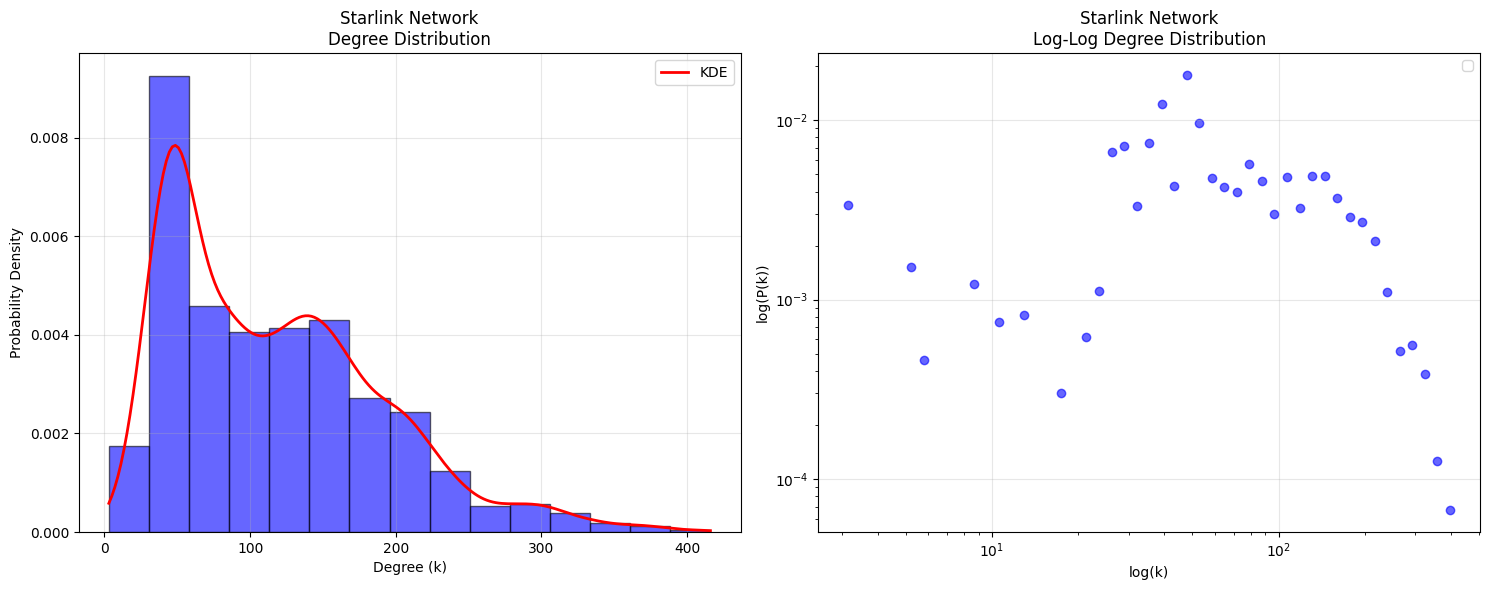

Normal distribution test p-value: 0.000000


In [53]:
def plot_improved_degree_distribution(graph, title):
    """
    Improved degree distribution plotting with better binning and statistical analysis
    
    Parameters:
    graph: networkx graph
    title: plot title
    """
    # Get degrees
    degrees = [degree for _, degree in graph.degree()]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # First plot: Regular scale with better binning
    # Use Freedman-Diaconis rule for optimal bin width
    q75, q25 = np.percentile(degrees, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(degrees) ** (1/3))
    n_bins = int(np.ceil((max(degrees) - min(degrees)) / bin_width))
    n_bins //= 2
    
    # Plot histogram with density=True for probability
    counts, bins, _ = ax1.hist(degrees, bins=n_bins, density=True, 
                              alpha=0.6, color='blue', edgecolor='black')
    
    # Add KDE plot
    kde = stats.gaussian_kde(degrees)
    x_range = np.linspace(min(degrees), max(degrees), 200)
    ax1.plot(x_range, kde(x_range), 'r-', lw=2, label='KDE')
    
    ax1.set_xlabel('Degree (k)')
    ax1.set_ylabel('Probability Density')
    ax1.set_title(f'{title}\nDegree Distribution')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Second plot: Log-log scale with logarithmic binning
    # Calculate log-binned degree distribution
    min_degree = min(degrees)
    max_degree = max(degrees)
    log_bins = np.logspace(np.log10(max(1, min_degree)),
                          np.log10(max_degree),
                          50)
    
    # Calculate probability distribution with log binning
    counts, bins = np.histogram(degrees, bins=log_bins, density=True)
    # Use bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot log-binned distribution
    ax2.scatter(bin_centers, counts, c='blue', alpha=0.6)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    # Fit power law using powerlaw package
    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.alpha
    xmin = fit.xmin
    
    # Generate fitted line points
    x = np.logspace(np.log10(xmin), np.log10(max_degree), 50)
    power_law = x ** (-alpha)
    # Normalize the power law
    power_law = power_law * (counts[0] / (x[0] ** (-alpha)))
    
    
    ax2.set_xlabel('log(k)')
    ax2.set_ylabel('log(P(k))')
    ax2.set_title(f'{title}\nLog-Log Degree Distribution')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Test normality
    _, p_normal = stats.normaltest(degrees)
    print(f"Normal distribution test p-value: {p_normal:.6f}")


# Example usage:
plot_improved_degree_distribution(satellite_network, "Starlink Network")

In [5]:
def average_shortest_path(graph):
    components = nx.connected_components(graph)
    total_path_length = 0
    total_nodes = 0

    for component in components:
        print(len(components))
        subgraph = graph.subgraph(component)
        total_path_length += nx.average_shortest_path_length(subgraph) * subgraph.number_of_nodes()
        total_nodes += subgraph.number_of_nodes()
    return total_path_length / total_nodes

In [9]:
satellite_clustering = nx.average_clustering(satellite_network)
print(f"Average clustering coefficient (Starlink Network): {satellite_clustering}")

random_clustering = nx.average_clustering(random_network)
print(f"Average clustering coefficient (Random Network): {random_clustering}")

snapshot_clustering = nx.average_clustering(snapshot_network)
print(f"Average clustering coefficient (Snapshot Network): {snapshot_clustering}")

satellite_shortest_path = average_shortest_path(satellite_network)
print(f"Average Shortest Path Length (Starlink Network): {satellite_shortest_path}")

snapshot_shortest_path = average_shortest_path(snapshot_network)
print(f"Average Shortest Path Length (Snapshot Network): {snapshot_shortest_path}")

random_shortest_path = nx.average_shortest_path_length(random_network)
print(f"Average clustering coefficient (Random Network): {random_shortest_path}")

Average clustering coefficient (Starlink Network): 0.7471722789801051
Average clustering coefficient (Random Network): 0.031120172500319596
Average clustering coefficient (Snapshot Network): 0.8148027580914751
Average Shortest Path Length (Starlink Network): 3.239755772480696
Average Shortest Path Length (Snapshot Network): 2.8850392632786526
Average clustering coefficient (Random Network): 1.9940337731108424


In [10]:
# assortativity coefficient
satellite_assortativity = nx.degree_pearson_correlation_coefficient(satellite_network)
print(f"Degree Assortativity (Satellite Network): {satellite_assortativity}")

random_assortativity = nx.degree_pearson_correlation_coefficient(random_network)
print(f"Degree Assortativity (Random Network): {random_assortativity}")

snapshot_assortativity = nx.degree_pearson_correlation_coefficient(snapshot_network)
print(f"Degree Assortativity (Snapshot Network): {snapshot_assortativity}")

Degree Assortativity (Satellite Network): 0.4419755568262563
Degree Assortativity (Random Network): 0.0015050932622161872
Degree Assortativity (Snapshot Network): 0.7175294253054336


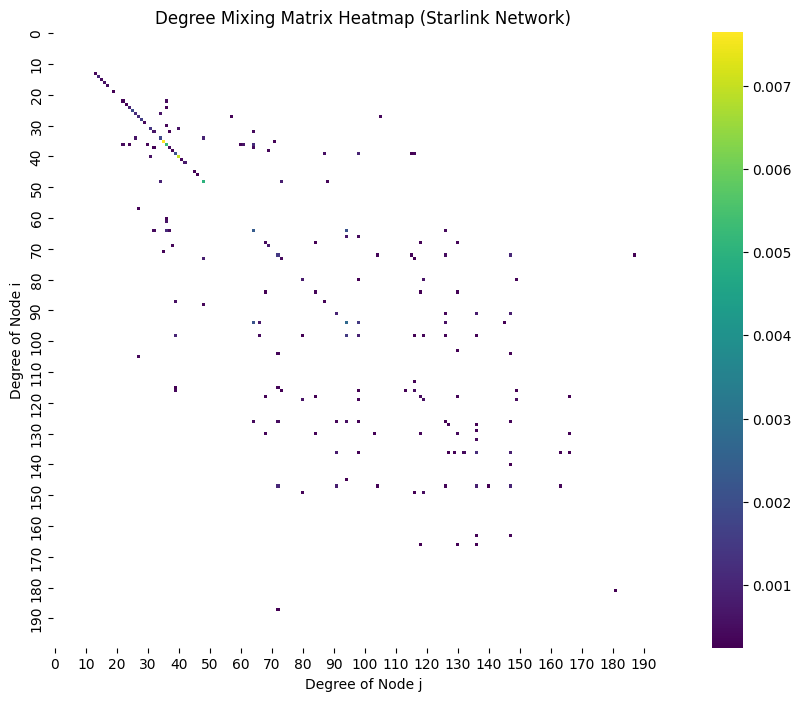

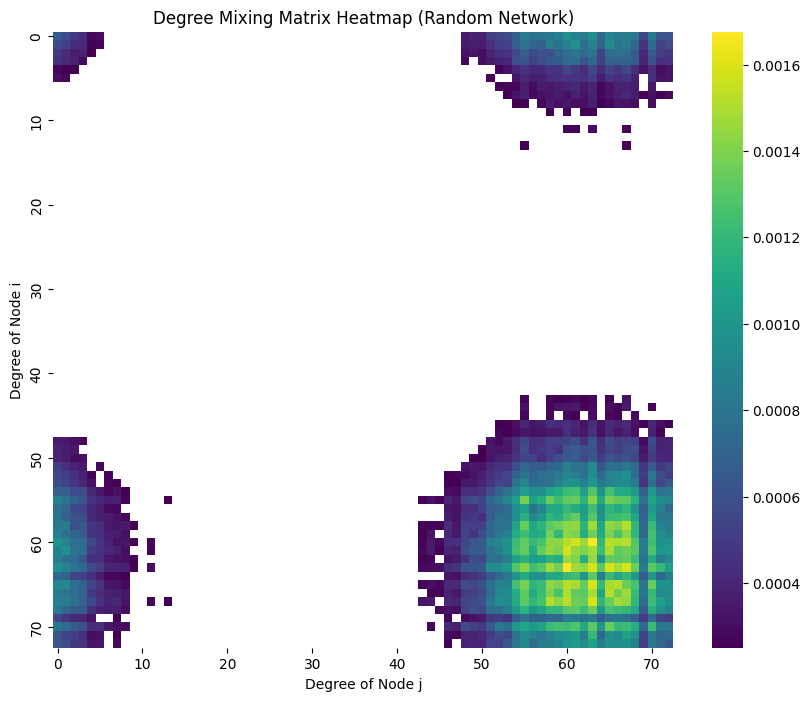

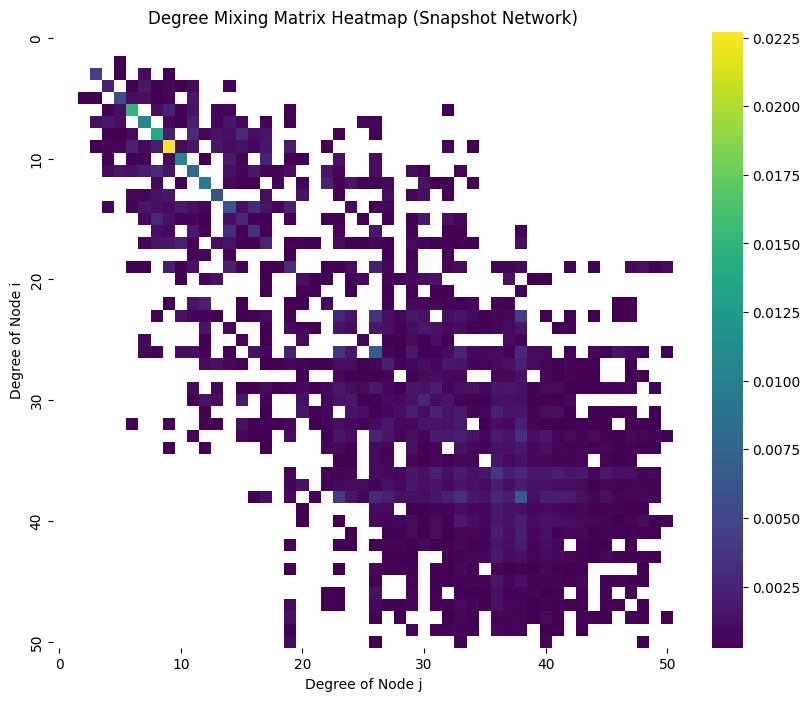

In [11]:
satellite__matrix = nx.degree_mixing_matrix(satellite_network)
random_matrix = nx.degree_mixing_matrix(random_network)
snapshot_matrix = nx.degree_mixing_matrix(snapshot_network)

def plot_mixing_heatmap(matrix, name):
    k_max = 200  # Set maximum degree to visualize
    trimmed_matrix = matrix[:k_max, :k_max]

    plt.figure(figsize=(10, 8))
    sns.heatmap(trimmed_matrix, cmap="viridis", annot=False, fmt='g', cbar=True,
                xticklabels=10, yticklabels=10,mask=(trimmed_matrix < 0.00025)) 
    plt.title(f"Degree Mixing Matrix Heatmap ({name})")
    plt.xlabel("Degree of Node j")
    plt.ylabel("Degree of Node i")
    plt.show()

plot_mixing_heatmap(satellite__matrix, 'Starlink Network')
plot_mixing_heatmap(random_matrix, 'Random Network')
plot_mixing_heatmap(snapshot_matrix, 'Snapshot Network')

In [41]:
# louvain communities output differ each run so for consistency of results please use the saved communities, unless otherwise you want to see new results
# louvain_communities = nx.community.louvain_communities(satellite_network)
# louvain_communities = sorted(louvain_communities, key=lambda x: len(x), reverse=True)

with open("networks/communities.txt") as f:
    louvain_communities = f.readlines()

louvain_communities = [set(community.split(",")) for community in louvain_communities]
louvain_communities = [[s.strip() for s in c] for c in louvain_communities]
louvain_communities = sorted(louvain_communities, key=lambda x: len(x), reverse=True)


In [42]:
satellite_modularity = nx.algorithms.community.quality.modularity(satellite_network, louvain_communities)
snapshot_modularity = nx.algorithms.community.quality.modularity(snapshot_network, nx.community.louvain_communities(snapshot_network))
random_modularity = nx.algorithms.community.quality.modularity(random_network, nx.community.louvain_communities(random_network))

print("Modularity of Starlink Network", satellite_modularity)
print("Modularity of Snapshot Network", snapshot_modularity)
print("Modularity of Random Network", random_modularity)

Modularity of Starlink Network 0.6456920496454592
Modularity of Snapshot Network 0.8170267236679795
Modularity of Random Network 0.07950351796635022


In [47]:
all_nodes = []
all_key_nodes = []
centrality =  nx.betweenness_centrality(satellite_network)

for comm_id, nodes in enumerate(louvain_communities, start=1):
    size = len(nodes)
    avg_degree = sum(dict(satellite_network.degree(nodes)).values()) / size
    
    nodes[-1] = nodes[-1].strip()
    key_nodes = sorted(nodes, key=lambda n: centrality[n.strip()], reverse=True)[:10]
    
    all_nodes.append(nodes)
    all_key_nodes.append(key_nodes)
    print(f"Community ID: {comm_id}, Size: {size}, Avg Degree: {avg_degree}, Key Nodes: {key_nodes}")


Community ID: 1, Size: 719, Avg Degree: 104.6884561891516, Key Nodes: ['STARLINK-5820', 'STARLINK-5595', 'STARLINK-5006', 'STARLINK-5640', 'STARLINK-1342', 'STARLINK-1374', 'STARLINK-5592', 'STARLINK-30482', 'STARLINK-5841', 'STARLINK-1275']
Community ID: 2, Size: 574, Avg Degree: 159.86933797909407, Key Nodes: ['STARLINK-2611', 'STARLINK-6222', 'STARLINK-4024', 'STARLINK-5872', 'STARLINK-31654', 'STARLINK-30961', 'STARLINK-30942', 'STARLINK-3547', 'STARLINK-2003', 'STARLINK-30926']
Community ID: 3, Size: 559, Avg Degree: 155.59928443649375, Key Nodes: ['STARLINK-5584', 'STARLINK-5613', 'STARLINK-5591', 'STARLINK-5499', 'STARLINK-5833', 'STARLINK-5544', 'STARLINK-4598', 'STARLINK-4109', 'STARLINK-4578', 'STARLINK-4605']
Community ID: 4, Size: 388, Avg Degree: 134.8479381443299, Key Nodes: ['STARLINK-5804', 'STARLINK-4070', 'STARLINK-3219', 'STARLINK-5825', 'STARLINK-1646', 'STARLINK-6326', 'STARLINK-2631', 'STARLINK-11275 [DTC]', 'STARLINK-32125', 'STARLINK-31526']
Community ID: 5, Siz

In [49]:
def get_cities(nodes):
    neighbours = set()
    for n in nodes:
        neighbours.update(list(bipartite_network.neighbors(n)))
    return list(neighbours)

cities = get_cities(all_key_nodes[0])
print(f"Number of Cities served by the top 10 nodes in the largest community: {len(cities)}, ", "Names of those Cities:",cities)

# returns the set of cities served by the largest community 
cities = get_cities(all_nodes[0])
print(f"Number of Cities served by the largest community: {len(cities)}, ", "Names of those Cities:",cities)

Number of Cities served by the top 10 nodes in the largest community: 53,  Names of those Cities: ['Gothenburg', 'Malmö', 'Västerås', 'Blantyre', 'Amadora', 'Uppsala', 'Olympia', 'Abbotsford', 'Liepāja', 'Vantaa', 'Santa Fe', 'Tallinn', 'Sacramento', 'Beira', 'Helsinki', 'Salem', 'Mombasa', 'Victoria', 'Copenhagen', 'Stockholm', 'Brasília', 'Kamloops', 'Lima', 'Seville', 'Lisbon', 'Ulaanbaatar', 'Hamburg', 'Bergen', 'Riga', 'Narva', 'Regina', 'Jūrmala', 'Helena', 'Pärnu', 'Espoo', 'Kelowna', 'Phoenix', 'Nampula', 'Arequipa', 'Tampere', 'Boise', 'Porto', 'Berlin', 'Tartu', 'Braga', 'Saskatoon', 'Salt Lake City', 'Vancouver', 'Edmonton', 'Jelgava', 'Denver', 'Kohtla-Järve', 'Coimbra']
Number of Cities served by the largest community: 85,  Names of those Cities: ['Stavanger', 'Tallinn', 'Mbabane', 'Sacramento', 'Beira', 'Helsinki', 'Lethbridge', 'Calgary', 'Hamburg', 'Bergen', 'Narva', 'Regina', 'Oslo', 'Helena', 'Arequipa', 'Salt Lake City', 'Maputo', 'Francistown', 'Malmö', 'Västerås', 

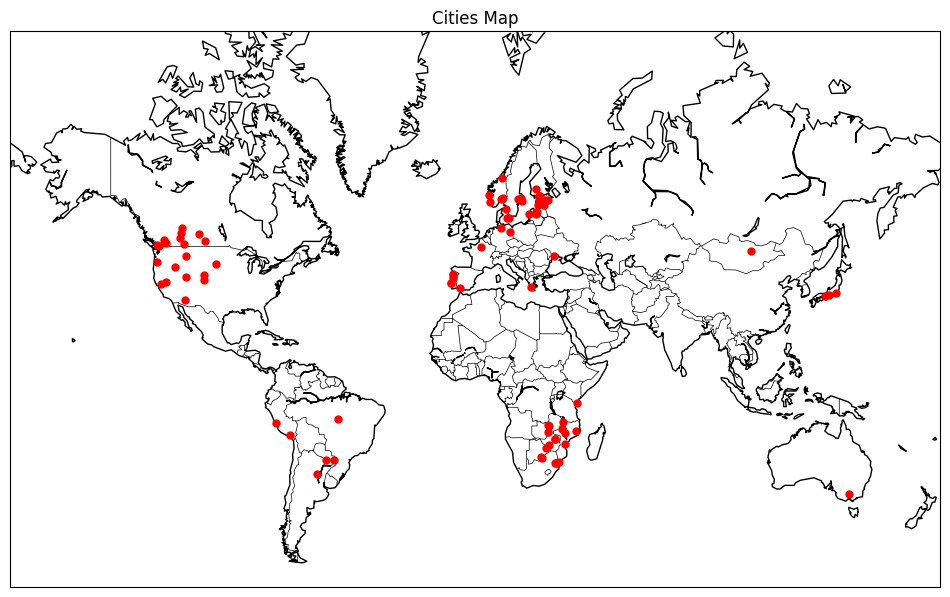

In [54]:
# outputs on a map the cities served by the largest community 

geolocator = Nominatim(user_agent="city_mapper", timeout=5)
fig, ax = plt.subplots(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80,
            llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcoastlines()
m.drawcountries()

for city in cities:
    try:
        location = geolocator.geocode(city)
        if location:
            x, y = m(location.longitude, location.latitude)
            m.plot(x, y, 'ro', markersize=5, label=city)
    except:
        print(f"Could not geocode: {city}")

plt.title("Cities Map")
plt.show()

In [63]:
# betweeness centrality
top_betweenness = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Satellites by Betweenness Centrality:")
top_satellites = []
for node, val in top_betweenness:
    print(f"Satellite: {node}, Centrality: {centrality[node]:.4f}")
    top_satellites.append(node)

Top 10 Satellites by Betweenness Centrality:
Satellite: STARLINK-5584, Centrality: 0.0322
Satellite: STARLINK-5613, Centrality: 0.0243
Satellite: STARLINK-5591, Centrality: 0.0237
Satellite: STARLINK-5499, Centrality: 0.0219
Satellite: STARLINK-5621, Centrality: 0.0210
Satellite: STARLINK-5833, Centrality: 0.0197
Satellite: STARLINK-2611, Centrality: 0.0160
Satellite: STARLINK-1596, Centrality: 0.0159
Satellite: STARLINK-5820, Centrality: 0.0157
Satellite: STARLINK-31846, Centrality: 0.0138


In [64]:
for s in top_satellites:
    n = list(bipartite_network.neighbors(s))
    a = len(n)

    for i, comm in enumerate(louvain_communities, start=1):
        if s in comm:
            print(f"Satellite: {s}, Number of Cities: {len(n)}, Cities: {n}, Community Number: {i}")
            break

Satellite: STARLINK-5584, Number of Cities: 28, Cities: ['Calgary', 'Edmonton', 'Saskatoon', 'Red Deer', 'Lethbridge', 'Antananarivo', 'Toamasina', 'Antsirabe', 'Budapest', 'Debrecen', 'Szeged', 'Miskolc', 'Pécs', 'Zagreb', 'Rijeka', 'Osijek', 'Kraków', 'Wrocław', 'Bratislava', 'Košice', 'Prešov', 'Timișoara', 'Vienna', 'Graz', 'Linz', 'Prague', 'Brno', 'Ostrava'], Community Number: 3
Satellite: STARLINK-5613, Number of Cities: 6, Cities: ['Saint Paul', 'Bismarck', 'Pierre', 'Winnipeg', 'Kyiv', 'Kharkiv'], Community Number: 3
Satellite: STARLINK-5591, Number of Cities: 14, Cities: ['Boise', 'Helena', 'Lethbridge', 'Berlin', 'Hamburg', 'Frankfurt', 'Łódź', 'Wrocław', 'Poznań', 'Vienna', 'Linz', 'Prague', 'Brno', 'Ostrava'], Community Number: 3
Satellite: STARLINK-5499, Number of Cities: 23, Cities: ['Edmonton', 'Saskatoon', 'Sofia', 'Plovdiv', 'Ruse', 'Thessaloniki', 'Budapest', 'Debrecen', 'Szeged', 'Pécs', 'Split', 'Osijek', 'Bucharest', 'Cluj-Napoca', 'Timișoara', 'Tirana', 'Pristina